In [1]:
# Importing necessary library
import pandas as pd

# Loading the dataset
data_path = "disaster_prediction.csv"  # Replace with the path to your dataset
data = pd.read_csv(data_path)

# Displaying the first few rows of the dataset
print(data.head())


   Year  Month   Day  ISO           Region Continent  \
0  1900    NaN   NaN  CPV   Western Africa    Africa   
1  1900    NaN   NaN  IND    Southern Asia      Asia   
2  1902    4.0  18.0  GTM  Central America  Americas   
3  1902    4.0   8.0  GTM  Central America  Americas   
4  1902   10.0  24.0  GTM  Central America  Americas   

                    Location Origin  Dis Mag Value Dis Mag Scale  Affected  \
0                Countrywide    NaN            NaN           Km2     11000   
1                     Bengal    NaN            NaN           Km2   1250000   
2  Quezaltenango, San Marcos    NaN            8.0       Richter      2000   
3                        NaN    NaN            NaN           NaN      1000   
4                        NaN    NaN            NaN           NaN      6000   

  Longitude Geo Locations  
0       NaN           NaN  
1       NaN           NaN  
2       -91           NaN  
3       NaN           NaN  
4       NaN           NaN  


In [2]:
#Data PreProcessing
# Fill missing values for 'Month' and 'Day' with 0
data['Month'].fillna(0, inplace=True)
data['Day'].fillna(0, inplace=True)

# Fill missing values for 'Location' and 'Origin' with 'Unknown'
data['Location'].fillna('Unknown', inplace=True)
data['Origin'].fillna('Unknown', inplace=True)

# One-hot encode the 'Region', 'Continent', and 'Location' columns
data = pd.get_dummies(data, columns=['Region', 'Continent', 'Location'])

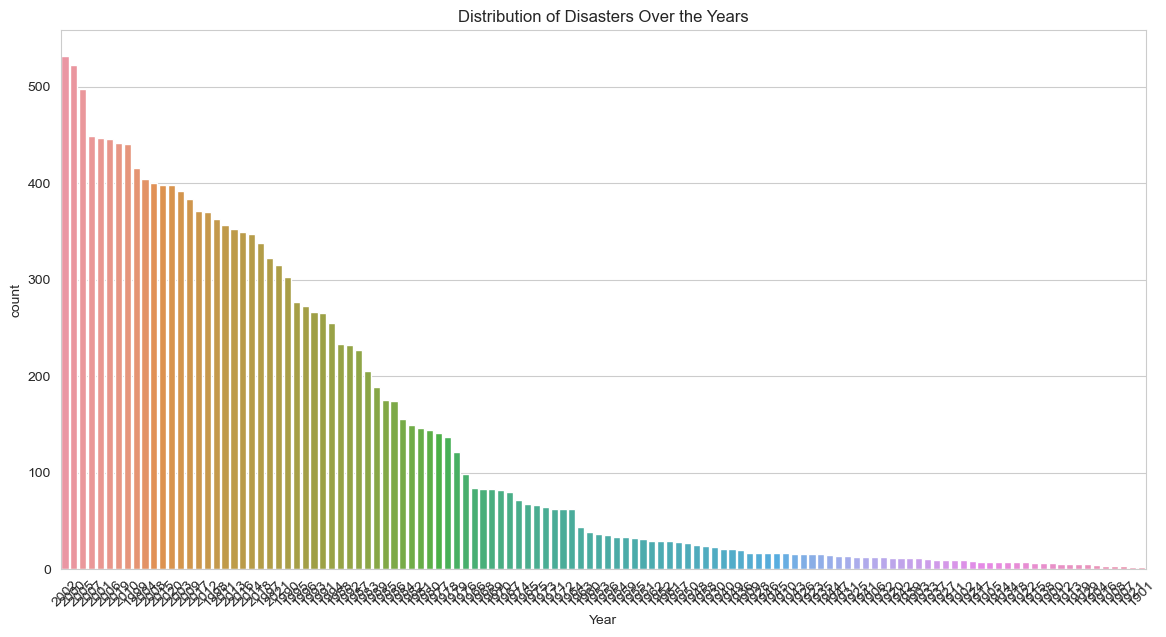

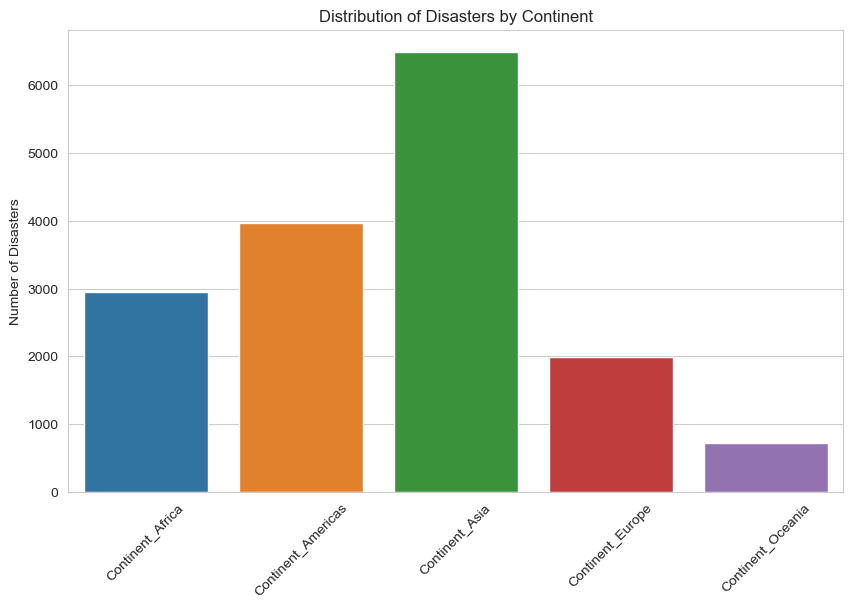

In [3]:
#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(14, 7))
sns.countplot(data=data, x='Year', order=data['Year'].value_counts().index)
plt.title('Distribution of Disasters Over the Years')
plt.xticks(rotation=45)
plt.show()

# Sum the one-hot encoded columns for each continent
continent_columns = [col for col in data.columns if 'Continent_' in col]
continent_counts = data[continent_columns].sum()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=continent_counts.index, y=continent_counts.values)
plt.title('Distribution of Disasters by Continent')
plt.xticks(rotation=45)
plt.ylabel('Number of Disasters')
plt.show()









In [4]:
#Data Splitting:
from sklearn.model_selection import train_test_split

# Features (Year in this case)
X = data[['Year']]

# Targets (Event occurrence, type, and continent)
y_event = data['Origin']  # Assuming 'Origin' represents the type of event
y_continent = data[[col for col in data.columns if 'Continent_' in col]]

# Splitting data
X_train, X_test, y_event_train, y_event_test, y_continent_train, y_continent_test = train_test_split(X, y_event, y_continent, test_size=0.2, random_state=42)


In [5]:
#Model Building
from sklearn.ensemble import RandomForestClassifier

# Model for event prediction
event_model = RandomForestClassifier()
event_model.fit(X_train, y_event_train)

# Model for continent prediction
continent_model = RandomForestClassifier()
continent_model.fit(X_train, y_continent_train)


RandomForestClassifier()

In [6]:
#Evaluation
from sklearn.metrics import accuracy_score

# Predictions
y_event_pred = event_model.predict(X_test)
y_continent_pred = continent_model.predict(X_test)

# Evaluation
event_accuracy = accuracy_score(y_event_test, y_event_pred)
continent_accuracy = accuracy_score(y_continent_test, y_continent_pred)

print(f"Event Prediction Accuracy: {event_accuracy * 100:.2f}%")
print(f"Continent Prediction Accuracy: {continent_accuracy * 100:.2f}%")


Event Prediction Accuracy: 76.97%
Continent Prediction Accuracy: 2.73%


In [19]:
#Lstm
#Model Building
# Necessary Imports
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
import numpy as np

# Normalize the 'Year' and 'Dis Mag Value' columns
data['Year'] = MinMaxScaler().fit_transform(data[['Year']])
# Handle missing values and normalize 'Dis Mag Value'
data['Dis Mag Value'].fillna(data['Dis Mag Value'].mean(), inplace=True)
data['Dis Mag Value'] = MinMaxScaler().fit_transform(data[['Dis Mag Value']])

# Label Encoding for the 'Origin' column
data['Origin'] = LabelEncoder().fit_transform(data['Origin'])

# Convert the dataset into sequences with multiple features
def create_sequences_multifeature(data, sequence_length):
    X, y_event, y_continent = [], [], []
    for i in range(len(data) - sequence_length):
        seq_data = data[['Year', 'Dis Mag Value']].iloc[i:i+sequence_length].values
        X.append(seq_data)
        y_event.append(data['Origin'].iloc[i+sequence_length])
        y_continent.append(data[[col for col in data.columns if 'Continent_' in col]].iloc[i+sequence_length].values)
    return np.array(X), np.array(y_event), np.array(y_continent)

# Define the sequence length and create the sequences
sequence_length = 10
X_seq, y_event_seq, y_continent_seq = create_sequences_multifeature(data, sequence_length)

# Split the data into training and testing sets
train_size = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_event_train_seq, y_event_test_seq = y_event_seq[:train_size], y_event_seq[train_size:]
y_continent_train_seq, y_continent_test_seq = y_continent_seq[:train_size], y_continent_seq[train_size:]

# Convert event labels to one-hot encoding
y_event_train_seq = to_categorical(y_event_train_seq, num_classes=num_event_types)
y_event_test_seq = to_categorical(y_event_test_seq, num_classes=num_event_types)

from keras.callbacks import EarlyStopping

# ... [previous preprocessing code]

# Adjusted Model Building
inputs = Input(shape=(sequence_length, 2))
lstm_out = LSTM(128, return_sequences=True)(inputs)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(64, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(32, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(16)(lstm_out)

# Event prediction branch
event_output = Dense(num_event_types, activation='softmax', name='event_output')(lstm_out)

# Continent prediction branch with added complexity
continent_dense = Dense(64, activation='relu')(lstm_out)
continent_dense = Dropout(0.2)(continent_dense)
continent_dense = Dense(32, activation='relu')(continent_dense)
continent_output = Dense(num_continents, activation='softmax', name='continent_output')(continent_dense)

model = Model(inputs=inputs, outputs=[event_output, continent_output])
model.compile(optimizer='adam',
              loss={'event_output': 'categorical_crossentropy', 'continent_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model with sample weights and early stopping
model.fit(X_train_seq,
          {'event_output': y_event_train_seq, 'continent_output': y_continent_train_seq},
          epochs=100,
          batch_size=64,
          validation_split=0.2,
          sample_weight={'event_output': sample_weights_event, 'continent_output': sample_weights_continent},
          callbacks=[early_stopping],
          verbose=1)

# Make predictions for events and continents
event_predictions, continent_predictions = model.predict(X_test_seq)

# Convert softmax outputs to class labels and compute F1 scores
f1_event = f1_score(np.argmax(y_event_test_seq, axis=1), np.argmax(event_predictions, axis=1), average='weighted')
f1_continent = f1_score(np.argmax(y_continent_test_seq, axis=1), np.argmax(continent_predictions, axis=1), average='weighted')
print(f"F1 Score for Event Prediction: {f1_event:.2f}")
print(f"F1 Score for Continent Prediction: {f1_continent:.2f}")




Epoch 1/100
162/162 [==============================] - 8s 24ms/step - loss: 5.5493 - event_output_loss: 3.9257 - continent_output_loss: 1.6235 - event_output_accuracy: 0.6402 - continent_output_accuracy: 0.2066 - val_loss: 18.4171 - val_event_output_loss: 16.8552 - val_continent_output_loss: 1.5619 - val_event_output_accuracy: 0.5964 - val_continent_output_accuracy: 0.0337
Epoch 2/100
162/162 [==============================] - 3s 19ms/step - loss: 5.3845 - event_output_loss: 3.7580 - continent_output_loss: 1.6265 - event_output_accuracy: 0.5425 - continent_output_accuracy: 0.1724 - val_loss: 21.0968 - val_event_output_loss: 19.5373 - val_continent_output_loss: 1.5595 - val_event_output_accuracy: 0.0000e+00 - val_continent_output_accuracy: 0.1249
Epoch 3/100
162/162 [==============================] - 3s 20ms/step - loss: 5.0888 - event_output_loss: 3.4634 - continent_output_loss: 1.6253 - event_output_accuracy: 9.6965e-05 - continent_output_accuracy: 0.1382 - val_loss: 23.7491 - val_eve

In [23]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.utils import to_categorical

# Model Building
inputs = Input(shape=(X_train_dense.shape[1],))
dense_out = Dense(128, activation='relu')(inputs)
dense_out = Dropout(0.2)(dense_out)
dense_out = Dense(64, activation='relu')(dense_out)
event_output = Dense(y_event_train_seq.shape[1], activation='softmax', name='event_output')(dense_out)
continent_output = Dense(y_continent_train_seq.shape[1], activation='softmax', name='continent_output')(dense_out)

model = Model(inputs=inputs, outputs=[event_output, continent_output])
model.compile(optimizer='adam',
              loss={'event_output': 'categorical_crossentropy', 'continent_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense,
                    {'event_output': y_event_train_seq, 'continent_output': y_continent_train_seq},
                    epochs=50,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)

# Make predictions
event_predictions = model.predict(X_test_dense)[0]
continent_predictions = model.predict(X_test_dense)[1]

# Convert softmax outputs to class labels
event_pred_labels = np.argmax(event_predictions, axis=1)
continent_pred_labels = np.argmax(continent_predictions, axis=1)

# Convert true labels (which are one-hot encoded) to class labels
true_event_labels = np.argmax(y_event_test_seq, axis=1)
true_continent_labels = np.argmax(y_continent_test_seq, axis=1)

# Compute F1 scores
f1_event = f1_score(true_event_labels, event_pred_labels, average='weighted')
f1_continent = f1_score(true_continent_labels, continent_pred_labels, average='weighted')

print(f"F1 Score for Event Prediction: {f1_event:.2f}")
print(f"F1 Score for Continent Prediction: {f1_continent:.2f}")



Epoch 1/50
162/162 [==============================] - 1s 2ms/step - loss: 3.6338 - event_output_loss: 2.1569 - continent_output_loss: 1.4769 - event_output_accuracy: 0.8067 - continent_output_accuracy: 0.3832 - val_loss: 4.1307 - val_event_output_loss: 2.7037 - val_continent_output_loss: 1.4270 - val_event_output_accuracy: 0.5964 - val_continent_output_accuracy: 0.3920
Epoch 2/50
162/162 [==============================] - 0s 2ms/step - loss: 2.4141 - event_output_loss: 0.9701 - continent_output_loss: 1.4440 - event_output_accuracy: 0.8493 - continent_output_accuracy: 0.3899 - val_loss: 4.0765 - val_event_output_loss: 2.6538 - val_continent_output_loss: 1.4227 - val_event_output_accuracy: 0.5964 - val_continent_output_accuracy: 0.3920
Epoch 3/50
162/162 [==============================] - 0s 2ms/step - loss: 2.2809 - event_output_loss: 0.8481 - continent_output_loss: 1.4329 - event_output_accuracy: 0.8493 - continent_output_accuracy: 0.3924 - val_loss: 3.6994 - val_event_output_loss: 2.2